In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, UpSampling2D, Embedding, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from keras.utils.vis_utils import plot_model
from livelossplot import PlotLossesKeras
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import backend as K
import tensorflow as tf
import keras, keras.layers as L, keras.backend as K
import numpy as np
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import cv2
from collections import Counter
import imutils
from imutils import paths
from keras.layers import BatchNormalization,Activation
from scipy.spatial.distance import cosine, euclidean
import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
from tensorflow import keras
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
train_data = "C:\\Users\\Aayush Kandpal\\Downloads\\archive (1)\\train"
val_data ="C:\\Users\\Aayush Kandpal\\Downloads\\archive (1)\\val"


In [5]:
class Autoencoder:
    
    @staticmethod
    def create(embedding_dim = 1024):
       
        input_img = tf.keras.Input(shape=(150, 150, 3))
        encoded = Conv2D(32, (3, 3), activation='relu', padding='same', name = "layer_0")(input_img)
        encoded = MaxPooling2D((2, 2), padding='same', name = "layer_1")(encoded)
        encoded = Conv2D(16, (3, 3), activation='relu', padding='same', name = "layer_2")(encoded)     
        encoded_flat = Flatten()(encoded) 
        embedding = Dense(embedding_dim, activation = "relu", name = "embedding")(encoded_flat)
        encoder = tf.keras.Model(input_img, embedding, name = "encoder")

        volShape = K.int_shape(encoded)

        flat_layer = Dense(K.int_shape(encoded_flat)[1])(embedding)
        reshaped_encod = Reshape((volShape[1],volShape[2], volShape[3]))(flat_layer)
        decoded = tf.keras.layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same', name = "layer_3")(reshaped_encod)
        decoded = UpSampling2D((2, 2), name = "layer_4")(decoded)
        decoded = tf.keras.layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', name = "layer_5")(decoded)
        outputs = tf.keras.layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same', name = "layer_6")(decoded)

        #decoder = tf.keras.Model(embeddingInputs, outputs)

        autoencoder = tf.keras.Model(input_img, outputs)

        return (encoder, autoencoder)

In [6]:

encoder, autoencoder = Autoencoder.create()


In [7]:
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
layer_0 (Conv2D)             (None, 150, 150, 32)      896       
_________________________________________________________________
layer_1 (MaxPooling2D)       (None, 75, 75, 32)        0         
_________________________________________________________________
layer_2 (Conv2D)             (None, 75, 75, 16)        4624      
_________________________________________________________________
flatten_1 (Flatten)          (None, 90000)             0         
_________________________________________________________________
embedding (Dense)            (None, 1024)              92161024  
_________________________________________________________________
dense_1 (Dense)              (None, 90000)            

In [8]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
layer_0 (Conv2D)             (None, 150, 150, 32)      896       
_________________________________________________________________
layer_1 (MaxPooling2D)       (None, 75, 75, 32)        0         
_________________________________________________________________
layer_2 (Conv2D)             (None, 75, 75, 16)        4624      
_________________________________________________________________
flatten_1 (Flatten)          (None, 90000)             0         
_________________________________________________________________
embedding (Dense)            (None, 1024)              92161024  
Total params: 92,166,544
Trainable params: 92,166,544
Non-trainable params: 0
_______________________________________________

In [9]:
train_ben="C:\\Users\\Aayush Kandpal\\Downloads\\archive (1)\\train\\ben_afflek"
val_ben="C:\\Users\\Aayush Kandpal\\Downloads\\archive (1)\\val\\ben_afflek"

train_elton="C:\\Users\\Aayush Kandpal\\Downloads\\archive (1)\\train\\elton_john"
val_elton="C:\\Users\\Aayush Kandpal\\Downloads\\archive (1)\\val\\elton_john"

train_jerry="C:\\Users\\Aayush Kandpal\\Downloads\\archive (1)\\train\\jerry_seinfeld"
val_jerry="C:\\Users\\Aayush Kandpal\\Downloads\\archive (1)\\val\\jerry_seinfeld"

train_mad="C:\\Users\\Aayush Kandpal\\Downloads\\archive (1)\\train\\madonna"
val_mad="C:\\Users\\Aayush Kandpal\\Downloads\\archive (1)\\val\\madonna"

train_min="C:\\Users\\Aayush Kandpal\\Downloads\\archive (1)\\train\\mindy_kaling"
val_min="C:\\Users\\Aayush Kandpal\\Downloads\\archive (1)\\val\\mindy_kaling"


In [10]:
def build_data(img_folder_path, normalize = True):
    label = img_folder_path.split("/")[-1]
    images = []
    img_paths = list(imutils.paths.list_images(img_folder_path))
    for img_path in img_paths:
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if normalize:
            image = image.astype('float32') / 255.
        image = cv2.resize(image, (150, 150))

        images.append(image)
    images = np.array(images)
    return images, label

In [11]:
ben_train, _ = build_data(train_ben)
ben_val, _ = build_data(val_ben)

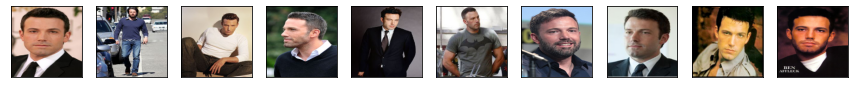

In [12]:
n = 10
plt.figure(figsize=(15, 10))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(ben_train[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [13]:
ben_train.shape,ben_val.shape

((14, 150, 150, 3), (5, 150, 150, 3))

In [14]:
liveplot = PlotLossesKeras()
BS = 8

autoencoder.compile(loss = 'mse', optimizer = 'adam')

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor=0.2, patience = 10, min_lr = 2e-5, mode = 'min')

callbacks = [liveplot, reduce_lr]

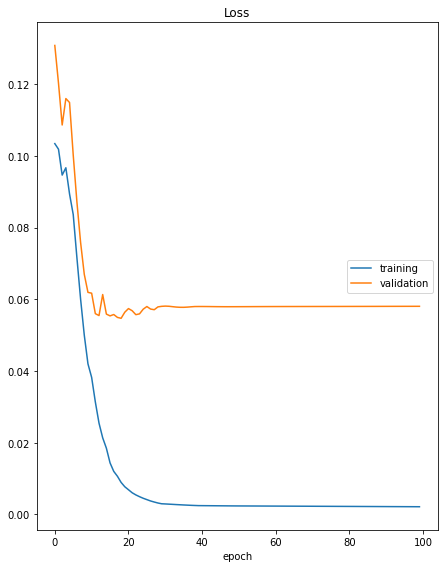

Loss
	training         	 (min:    0.002, max:    0.103, cur:    0.002)
	validation       	 (min:    0.055, max:    0.131, cur:    0.058)
2/2 [==============================] - 2s 1s/step - loss: 0.0021 - val_loss: 0.0581


In [15]:
training_history = autoencoder.fit(ben_train,ben_train,
                                   validation_data = (ben_val,ben_val),
                                   epochs = 100,
                                   verbose = 1,
                                   batch_size = BS,
                                   shuffle = True,
                                   callbacks = callbacks)

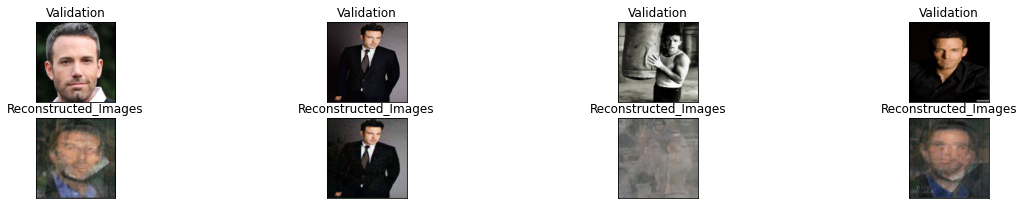

In [16]:
decoded_imgs = autoencoder.predict(ben_val)


n = 4
plt.figure(figsize=(20, 5))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(3, n, i)
    plt.imshow(ben_val[i]);
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title("Validation")    

    # Display reconstruction
    ax = plt.subplot(3, n, i + n)
    plt.imshow(decoded_imgs[i]);
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title("Reconstructed_Images")


plt.show();

In [17]:
# Callbacks
c1=ReduceLROnPlateau(monitor = 'val_loss', factor=0.2, patience = 10, min_lr = 2e-5, mode = 'min')
c2=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=6,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

In [18]:
#liveplot1 = PlotLossesKeras()
training_history = autoencoder.fit(ben_train,ben_train,
                                   validation_data = (ben_val,ben_val),
                                   epochs = 100,
                                   verbose = 1,
                                   batch_size = BS,
                                   shuffle = True,
                                   callbacks = [c1,c2])#liveplot1])

Epoch 1/100
2/2 [==============================] - 2s 979ms/step - loss: 0.0021 - val_loss: 0.0581
Epoch 2/100
2/2 [==============================] - 2s 870ms/step - loss: 0.0021 - val_loss: 0.0581
Epoch 3/100
2/2 [==============================] - 2s 897ms/step - loss: 0.0021 - val_loss: 0.0581
Epoch 4/100
2/2 [==============================] - 2s 806ms/step - loss: 0.0021 - val_loss: 0.0581
Epoch 5/100
2/2 [==============================] - 2s 838ms/step - loss: 0.0021 - val_loss: 0.0581
Epoch 6/100
2/2 [==============================] - 2s 835ms/step - loss: 0.0021 - val_loss: 0.0581
Epoch 7/100
2/2 [==============================] - 2s 848ms/step - loss: 0.0021 - val_loss: 0.0581
Epoch 00007: early stopping


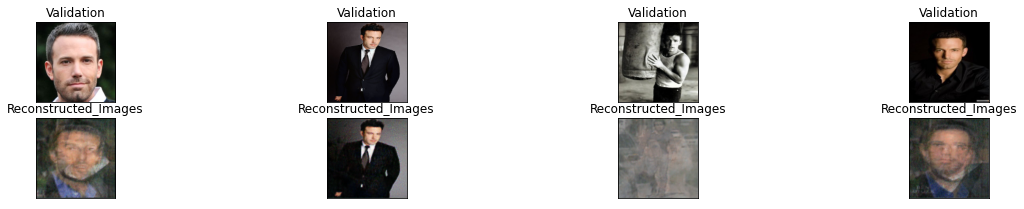

In [19]:
decoded_imgs = autoencoder.predict(ben_val)


n = 4
plt.figure(figsize=(20, 5))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(3, n, i)
    plt.imshow(ben_val[i]);
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title("Validation")    

    # Display reconstruction
    ax = plt.subplot(3, n, i + n)
    plt.imshow(decoded_imgs[i]);
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title("Reconstructed_Images")


plt.show();

In [20]:
#In Development. More data will improve the model exponentially